# ConectOR v2 (Conect Orthologue RNAs)

In [1]:
### IMPORTS
import argparse
import os, sys
import json
import wget
import gzip
import subprocess
import pandas as pd
import multiprocessing as mp
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx
from os import path, listdir
from collections import Counter


### Dictionaris
with open('dictionaries.json') as f:
    dictionaries = json.load(f)
    
def check_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)


#Only for jupyter
from IPython.display import IFrame
minMatch = 30
gene_level = True

In [ ]:
## Not needed for jupyter
#Options from command line
parser = argparse.ArgumentParser(description = "ConnectOR (v.1.0)"\
                                               "By: Carlos Pulido (carlos.pulido@dbmr.unibe.ch)")


def range_limited_int_type(arg):
    """ Type function for argparse - an int within some predefined bounds """
    try:
        i = int(arg)
    except ValueError:    
        raise argparse.ArgumentTypeError("Must be an integer")
    if i < 1 or i > 99:
        raise argparse.ArgumentTypeError("Argument must be < " + str(1) + " and > " + str(99) + ". Default: 30")
    return i


parser.add_argument('-mM', '--minMatch',
                    required = False,
                    default = '30',
                    action = 'store',
                    dest = 'minMatch',
                    type = range_limited_int_type,
                    help = '0.N Minimum ratio of bases that must remap in liftOver step.'\
                           'Default: 30 (0.30 minimum ratio)')

parser.add_argument('-g', '--gene',
                    dest = 'gene_level',
                    action = 'store_true',
                    default = False,
                    help = 'Generate results at gene level along with exon level results (default: False)')

#Storing user options
options = parser.parse_args()
gene_level = options.gene_level
minMatch = options.minMatch

In [2]:
## Functions
def assign_simplified_geneType(Type):
    type_dict = {"none": ["none"],
                 "pc": ["protein_coding", "pc"],
                 "ncRNA": ["NOVEL", "stringtie", "3prime_overlapping_ncRNA", "antisense", "bidirectional_promoter_lncRNA", "lincRNA", "ncRNA",
                           "non_coding", "processed_transcript", "sense_intronic", "sense_overlapping", "lncRNA", "snoRNA", "snRNA", "sRNA", 
                           "misc_RNA", "rRNA", "scaRNA", "miRNA", "TEC", "scRNA", "macro_lncRNA",
                           "pseudogene", "transcribed_processed_pseudogene", "translated_processed_pseudogene", "polymorphic_pseudogene", "processed_pseudogene", "rRNA_pseudogene",
                           "transcribed_unitary_pseudogene", "transcribed_unprocessed_pseudogene", "unitary_pseudogene", "unprocessed_pseudogene", "translated_unprocessed_pseudogene"],
                 "other": ["other", "IG_V_pseudogene", "IG_C_pseudogene", "IG_V_gene", "IG_C_gene", "IG_J_gene", "TR_J_pseudogene", "IG_J_pseudogene", "IG_pseudogene", "IG_D_pseudogene", 
                           "ribozyme", "vault_RNA", "vaultRNA", "TR_C_gene", "TR_J_gene", "TR_V_gene", "TR_V_pseudogene", "TR_D_gene", "IG_D_gene", "Mt_tRNA", "Mt_rRNA", "IG_LV_gene"]}
    biotype = [t for t in type_dict if Type in type_dict[t]]
    if biotype == []: biotype = ["ncRNA"]
    return(biotype[0])


def read_config(file_name):
    config_df =  pd.read_csv(file_name, sep='\t', na_filter= False)
    return(config_df)


def check_folder(folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
        

def check_file(file_name_list):
    for file_name in file_name_list:
        if not os.path.isfile(file_name):
            print("'%s' doesn not exist. Please check config_file. Exiting..."%(file_name))
            sys.exit(1)
            

def change_default(feature, value, config_df, i):
    default_values = config_df.loc[i]["default"].split("|")
    if feature == "gtf": 
        n = 0
    else:
        n = 1
    default_values[n] = value
    return("|".join(default_values))


def download_default_files(file_url, folder_name):
    check_folder(folder_name)
    file_name = file_url.split("/")[-1]
    if not os.path.isfile("/".join([folder_name, file_name])):
        wget.download(file_url, folder_name)
        print('\t%s downloaded succesfully..'%(file_name))
    else:
        print('\t%s already exists.. Skipping'%(file_name))


def arguments_dic(line):
    args = line[-1].split(";")
    dic = {}
    for e in args:
        if e == ";": continue
        if e == "": continue
        if e[0] == " ": e = e[1:]
        key = e.split(" ")[0].replace("\"","")
        dic[key] = e.split(" ")[1].replace("\"","")
    return dic


def biotype(keys, arguments):
    biotype=''
    while not biotype:
        for k in keys:
            try:
                biotype = arguments[k]
                return(biotype)
            except KeyError:
                pass
        if not biotype: biotype = "NOVEL"
        return(biotype)


#def generate_maps(gtf, sp):
def generate_maps(arg_list):

    gtf = arg_list[0]
    sp = arg_list[1]
    print("\tMaps for %s... generating\n"%(sp))
    
    if gtf.endswith(".gz"):
        f = gzip.open(gtf, 'rb')
        compressed = True
    else:
        f = open(gtf, 'r')
        compressed = False
        
    genes = {}

    for line in f:
        if compressed: line = str(line, 'utf-8')
        if line.startswith("#"): continue
        line = line.strip().split("\t")
        arguments = arguments_dic(line)

        if "gene_name" in arguments:
            gene_name = arguments["gene_name"]
        else:
            gene_name = arguments["gene_id"]

        geneID = arguments["gene_id"]
        gene_biotype = biotype(["gene_type", "gene_biotype"], arguments)
        gene_biotype = assign_simplified_geneType(gene_biotype)
        if line[2] == "exon":
            if not geneID in genes:
                genes[geneID] = {"gene_name": gene_name,
                                 "gene_type": gene_biotype,
                                 "coordinates": [line[0],line[3],line[4],line[6]],
                                 "transcripts": []}
                
            transcriptID = arguments["transcript_id"]
            if not transcriptID in genes[geneID]["transcripts"]:
                genes[geneID]["transcripts"].append(transcriptID)
            
            exon_start = line[3]
            exon_end = line[4]
            if int(exon_start) < int(genes[geneID]["coordinates"][1]): genes[geneID]["coordinates"][1] = exon_start
            if int(exon_end) > int(genes[geneID]["coordinates"][2]): genes[geneID]["coordinates"][2] = exon_end
            
            #Update gene biotype; protein_coding prevail other biotypes
            if genes[geneID]["gene_type"] == gene_biotype or genes[geneID]["gene_type"] == "protein_coding":
                continue
            else:
                genes[geneID]["gene_type"] = gene_biotype


            
    fo = open("maps/"+sp+".geneID_map.txt", 'w')
    for g in genes:
        line = "\t".join([g, genes[g]["gene_name"], genes[g]["gene_type"], ":".join(genes[g]["coordinates"]), "|".join(genes[g]["transcripts"])])
        fo.write(line+"\n")
    fo.close()
    print("\tMaps for %s... generated "%(sp))
    
    
#def generate_beds(gtf, sp, gene_level):
def generate_beds(arg_list):
    
    gtf = arg_list[0]
    sp = arg_list[1]
    gene_level = arg_list[2]
    if gtf.endswith(".gz"):
        f = gzip.open(gtf, 'rb')
        compressed = True
    else:
        f = open(gtf, 'r')
        compressed = False

    print("\tBEDs for %s... generating\n"%(sp))
    genes = {}
    output_exons = open("./BEDs/{}.exons.bed".format(sp),"w")
    for line in f:
        if compressed: line = str(line, 'utf-8')
        if line.startswith("#"): continue
        line = line.strip().split("\t")

        if line[2] != "exon": continue
        arguments = arguments_dic(line)

        if "gene_name" in arguments:
            gene_name = arguments["gene_name"]
        else:
            gene_name = arguments["gene_id"]
            
        gene_id = arguments["gene_id"]
        chrom = line[0] if line[0].startswith("chr") else "chr"+line[0]
        start = str(int(line[3])-1)
        end = line[4]
        strand = line[6]
        
        coordiantes = ":".join([chrom, start, end, strand])
        exon_id = "|".join([gene_id, gene_name, coordiantes])
        
        if int(start) < 0: start = "0"
        if not gene_id in genes:
            genes[gene_id] = {"chrom": chrom, 
                              "start": int(start),
                              "end": int(end),
                              "strand": strand,
                              "gene_name": gene_name}
        else:
            if int(start) < genes[gene_id]["start"]:
                genes[gene_id]["start"] = int(start)
            if int(end) > genes[gene_id]["end"]:
                genes[gene_id]["end"] = int(end)

        exon_bed_line = "\t".join([chrom, start, end, exon_id, '0', strand])+"\n"
        output_exons.write(exon_bed_line)
    output_exons.close()
    
    if gene_level:
        output_genes = open("./BEDs/{}.genes.bed".format(sp),"w")
        for gene in genes:
            d = genes[gene]
            chrom = d["chrom"]
            start = str(d["start"])
            end = str(d["end"])
            strand = d["strand"]
            gene_name = d["gene_name"]

            coordiantes = ":".join([chrom, start, end, strand])
            gene_id = "|".join([gene, gene_name, coordiantes])
        
            gene_bed_line = "\t".join([chrom, start, end, gene_id, '0', strand])+"\n"
            output_genes.write(gene_bed_line)
        output_genes.close()
    print("\r\tBEDs for %s... generated "%(sp))
    
    
def bed_sort():
    files = dirs = os.listdir("./BEDs/")
    for file_name in files:
        print("\r\t"+file_name+"... sorting", end="")
        call = "sort -u -k1,1 -k2,2n -o '%s' '%s'"%("./BEDs/"+file_name,"./BEDs/"+file_name)    
        subprocess.call(call, shell=True)
        print("\r\t"+file_name+"... sorted ")
        

def liftOver(arg_list):
    sp1 = arg_list[0]
    sp2 = arg_list[1]
    feature = arg_list[2]
    mM = arg_list[3]
    
    print("\t{} {} to {}... mapping\n".format(sp1, feature, sp2))
    oldFile = "BEDs/{}.{}.bed".format(sp1, feature)
    map_chain = [chain for chain in config_df.loc[config_df["assembly_version"]==sp1, "chainmap"].iloc[0].split(",") if sp2 in chain.lower()][0]
    newFile = "liftovers/{}to{}.{}.liftover".format(sp1, sp2, feature)
    unMapped= "liftovers/{}to{}.{}.unmapped".format(sp1, sp2, feature)
    os.system("./scripts/liftOver -minMatch={} {} {} {} {}".format(mM/100, oldFile, map_chain, newFile, unMapped))
    print("\t{} {} to {}... done         ".format(sp1, feature, sp2))
    
    
def geneID_map_to_dict(file_name, dl = "\t"):
    dict_ = {}
    with open(file_name, 'r') as f:
        for line in f:
            line = line.strip().split(dl)
            dict_[line[0]] = {"gene_name": line[1],
                              "gene_type": line[2],
                              "coordinates": line[3],
                              "transcript_IDs": line[4].split("|")}                              
    return(dict_)


def parse_orthologs(line):
    geneA_ID = line[0]
    geneA_biotype = line[1]
    geneB_IDs = line[2].split(",")
    nexon = line[3].split(",")
    pcent = line[4].split(",")
    geneB_biotypes = line[5].split(",")

    return(geneA_ID, geneA_biotype, geneB_IDs, nexon, pcent, geneB_biotypes)


def count_biotypes(geneB_biotypes):
    tmp   = []
    none  = ["none"]
    pc    = ["protein_coding", "pc"]
    ncRNA = ["NOVEL", "ncRNA", "stringtie", "3prime_overlapping_ncRNA", "antisense", "bidirectional_promoter_lncRNA", "lincRNA",
             "non_coding", "processed_transcript", "sense_intronic", "sense_overlapping", "lncRNA", "snoRNA", "snRNA", "sRNA", 
             "misc_RNA", "rRNA", "scaRNA", "miRNA", "TEC", "scRNA", "macro_lncRNA",
             "pseudogene", "transcribed_processed_pseudogene", "translated_processed_pseudogene", "polymorphic_pseudogene", "processed_pseudogene", "rRNA_pseudogene",
             "transcribed_unitary_pseudogene", "transcribed_unprocessed_pseudogene", "unitary_pseudogene", "unprocessed_pseudogene", "translated_unprocessed_pseudogene"]
    other = ["IG_V_pseudogene", "IG_C_pseudogene", "IG_V_gene", "IG_C_gene", "IG_J_gene", "TR_J_pseudogene", "IG_J_pseudogene", "IG_pseudogene", "IG_D_pseudogene", 
             "ribozyme", "vault_RNA", "TR_C_gene", "TR_J_gene", "TR_V_gene", "TR_V_pseudogene", "TR_D_gene", "IG_D_gene", "Mt_tRNA", "Mt_rRNA", "IG_LV_gene"]
    
    for type_ in geneB_biotypes:
        if type_ in none:
            tmp.append("none")
        elif type_ in ncRNA:
            tmp.append("lncRNA")
        elif type_ in pc:
            tmp.append("pc")
        else:
            tmp.append("other")
    
    biotype_counts = [tmp.count("none"), tmp.count("lncRNA"), tmp.count("pc"), tmp.count("other")]
    classification = classify_biotypes(biotype_counts)
    
    return(biotype_counts, classification)


def classify_biotypes(bcounts):
    classification = "other"
    #unique cases
    #  none              lncRNA            pc                other
    if bcounts[0]==1 and bcounts[1]==0 and bcounts[2]==0 and bcounts[3]==0:
        classification = "none"
    if bcounts[0]>=0 and bcounts[1]==1 and bcounts[2]==0 and bcounts[3]==0:
        classification = "lncRNA"
    if bcounts[0]>=0 and bcounts[1]==0 and bcounts[2]==1 and bcounts[3]==0:
        classification = "pc"
    if bcounts[0]>=0 and bcounts[1]==0 and bcounts[2]==0 and bcounts[3]==1:
        classification = "other"

    #multiple cases
    #  none              lncRNA            pc                other
    if bcounts[0]>1  and bcounts[1]==0 and bcounts[2]==0 and bcounts[3]==0:
        classification = "nones"
    if bcounts[0]>=0 and bcounts[1]>1  and bcounts[2]==0 and bcounts[3]==0:
        classification = "lncRNAs"
    if bcounts[0]>=0 and bcounts[1]==0 and bcounts[2]>1  and bcounts[3]==0:
        classification = "pcs"
    if bcounts[0]>=0 and bcounts[1]==0 and bcounts[2]==0 and bcounts[3]>1:
        classification = "others"

    #dual cases
    #  none              lncRNA            pc                other
    if bcounts[0]>=0 and bcounts[1]>=1 and bcounts[2]>=1 and bcounts[3]>=0:
        classification = "lncRNA_PC"
    if bcounts[0]>=0 and bcounts[1]>=1 and bcounts[2]==0 and bcounts[3]>=1:
        classification = "lncRNA_other"
    if bcounts[0]>=0 and bcounts[1]==0 and bcounts[2]>=1 and bcounts[3]>=1:
        classification = "PC_other"

    return(classification)


def generate_components_stats(components, G):
    x_to_comp_idx = {}
    comp_idx_x = {}
    for idx,c in enumerate(components):

        s = G.subgraph(c)
        edges = s.edges()    
        edges_set = set(edges)
        nodes = []
        links = []
        for gene in c:
            #gene[1]=GeneName; idx=cluster_id; gene=tuple(sp, GeneName, GeneBiotype) 
            x_to_comp_idx[gene[1]] = {"idx": idx, "node": gene}

        for edge in edges:

            #G.has_edge(node1, node2)
            sps_in_edge = [node[0] for node in edge]
            is_bidirectional = 1 if (edge[1],edge[0]) in edges_set else 0
            l1 = list(edge)
            #1=edge is bidirectional; 2=edge is unidirectional
            l1.append(is_bidirectional if is_bidirectional else 2)
            links.append(tuple(l1))

            n1 = list(edge[0])
            n2 = list(edge[1])
            #1=gene has bidirectional prediction; 2=gene has unidirectional prediction; 3=gene has no prediction
            if is_bidirectional:
                n1.append(1)
                nodes.append(tuple(n1))
            else:
                n1.append(2)
                n2.append(3)           
                nodes.append(tuple(n1))
                nodes.append(tuple(n2))

        #bidirectionality = True: returns only nodes instead of edges and counts of ocurrences for each node
        comp_idx_x[idx] = {"bidirectional": Counter(nodes),
                           "links": links}
    return(x_to_comp_idx, comp_idx_x)


def plot_component(g, dictionary = {"hg38": "lightgreen", "mm10": "lightblue", "danrer11": "yellow"}):
    org_color = dictionary
    fig,ax = plt.subplots(figsize=(8,8))
    nodes = g.nodes()
    edges = g.edges()    
    edges_set = set(edges)
    bidirectional = [True if (v[1],v[0]) in edges_set else False for v in edges]
    edge_color = ['red' if x else 'gray' for x in bidirectional]
    node_color = [org_color[x[0]] for x in nodes]
    labels = {x:x[1] for x in nodes} ############### cambiar x[1] por tu_dictionary[x[1]]!
    pos=nx.spring_layout(g)    
    nx.draw_networkx_nodes(g,pos,nodelist=nodes,node_color=node_color)
    nx.draw_networkx_edges(g,pos,edgelist=edges,edge_color=edge_color)
    nx.draw_networkx_labels(g,pos,labels,font_weight='bold')
    plt.legend(handles=[mpatches.Patch(color=v, label=k) for k,v in org_color.items()],
               bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.axis('off')
    plt.show()
    
    
def get_clusters_stats(components, G, level, output_path="./counts/", species_names=False):
    if species_names:
        species = species_names
    else:
        species = sps.keys()
        
    #Biotypes accepted for ncRNA clusters
    ncrna_bt = ["NOVEL", "stringtie", "3prime_overlapping_ncRNA", "antisense", "bidirectional_promoter_lncRNA", "lincRNA", "ncRNA",
                "non_coding", "processed_transcript", "sense_intronic", "sense_overlapping", "lncRNA", "snoRNA", "snRNA", "sRNA", 
                "misc_RNA", "rRNA", "scaRNA", "miRNA", "TEC", "scRNA", "macro_lncRNA",
                "pseudogene", "transcribed_processed_pseudogene", "translated_processed_pseudogene", "polymorphic_pseudogene", "processed_pseudogene", "rRNA_pseudogene",
                "transcribed_unitary_pseudogene", "transcribed_unprocessed_pseudogene", "unitary_pseudogene", "unprocessed_pseudogene", "translated_unprocessed_pseudogene"]
    
    #Check input/output names
    if not path.exists(output_path):
        os.makedirs(output_path)
    
    if species_names:
        o_name = "".join([species_names[0],"_", species_names[1], "_"])
    else: 
        o_name = ""
        
    output_cluster_stats = path.join(output_path, '%scluster_stats_%s.csv'%(o_name, level))
    output_genes_stats   = path.join(output_path, '%sgenes_stats_%s.csv'%(o_name, level))    
    
    org_all_count = list(species)
    
    #Total genes
    total_genes = len(G.nodes())
    
    #Map with full name of genes
    map_fileNames = [f for f in os.listdir("maps")]
    map_dictionary = {}
    for fileName in map_fileNames:
        df_maps = pd.read_csv("maps/"+fileName, sep='\t', na_filter= False, header=None, names=["geneID", "geneName", "biotype", "coordinates", "transcripts"])
        df_maps["fullID"] = df_maps["geneID"]+";"+df_maps["geneName"]+";"+df_maps["biotype"]+";"+df_maps["coordinates"]
        df_maps = df_maps[["geneID", "fullID"]].set_index('geneID').to_dict()["fullID"]
        map_dictionary.update(df_maps)
    
    #Liftover genes dictionary
    liftovers = {level: {}}
    liftovers_set = set()
    liftover_fileNames = [f for f in os.listdir("liftovers") if "liftover" in f and level in f]
    for fileName in liftover_fileNames:
      
        name = fileName.split(".")
        sp1 = name[0].split("to")[0]
        sp2 = name[0].split("to")[1]
        
        if not sp1 in liftovers[level]:
            liftovers[level][sp1] = {}

        df_liftovers = pd.read_csv("liftovers/"+fileName, sep='\t', na_filter= False, header=None, names=["chrom", "start", "end", "id", "score", "strand"])  
        df_liftovers['id'] = df_liftovers['id'].apply(lambda x:[y for y in x.split("|")])
        df_set = set(df_liftovers['id'].apply(lambda x: x[0]))
        
        liftovers_set.update(df_set)
        liftovers[level][sp1][sp2] = df_set


    #Headers for output files
    header_stats = ['Cluster ID','Nodes','Number of species', 'Bidirectionality', 'Cluster type', 'Biotypes']
    header_genes = ['Gene ID','Species', 'Biotype', 'Cluster ID', 'Cluster Biotype', 'Cluster type', 'Orthologues', 'in_degree','out_degree']
    
    for sp in species:
        header_stats += ['has_'+sp, 'count_'+sp, 'Gene IDs '+sp]
        header_genes.insert(6, 'Gene to '+sp)
        
    o1 = open(output_cluster_stats,'w')
    o1.write(','.join(header_stats)+'\n')
    o2 = open(output_genes_stats,'w')
    o2.write(','.join(header_genes)+'\n')
    
    #Iterate over clusters
    for idx,c in enumerate(components):
        g = G.subgraph(c)
        nodes = g.nodes()
        edges = g.edges()
        edges_set = set(edges)
        print("\r%.2f%s Cluster %s of %s (%s genes in cluster)"%(int(idx)/len(components)*100, "%", str(idx), str(len(components)), str(len(g.nodes()))) , end= "\r", file=sys.stderr)

        #Bidirectionality in the cluster
        is_bidirectional = [1 if (v[1],v[0]) in edges_set else 0 for v in edges]
        bidirectional = 0 if len(edges) == 0 else sum(is_bidirectional)/len(edges)
        
        #Biotypes in cluster
        biotypes = set([n[2] for n in nodes])
        if len(biotypes) == 1:
            cluster_biotype = biotypes.pop()
        else:
            cluster_biotype = "other"

        #Nodes per species in cluster
        org_comp_count_ugly = Counter([x[0] for x in nodes])
        org_comp_count = {k:v for k,v in org_comp_count_ugly.items()}
        for sp in species:
            if sp not in org_comp_count:
                org_comp_count[sp] = 0
        n_species = sum([1 for sp in org_comp_count if org_comp_count[sp] > 0])
        
        #Cluster data
        data = {'Cluster ID': str(idx),
                'Nodes': str(len(nodes)),
                'Number of species': str(n_species),
                'Bidirectionality': '%.2f'%(bidirectional),
                'Biotypes': cluster_biotype}
        
        for sp in species:
            data['has_'+sp] = str(int(org_comp_count[sp]>0))
            data['count_'+sp] = str(org_comp_count[sp])
            data['per_cluster_'+sp] = '%.2f'%(100*org_comp_count[sp]/len(nodes))
            data['per_total_'+sp] = '%.2f'%(100*org_comp_count[sp]/total_genes)
            data['Gene IDs '+sp] = "|".join([map_dictionary[n[1]] for n in nodes if n[0]==sp])
            
        #Cluster type
        cluster_type=''
        has_list = [int(data[x]) for x in data if x.startswith("has")]      
        count_list = [int(data[x]) for x in data if x.startswith("count")]
                
        if len(nodes) == 1:
            cluster_type = 'One to none' if list(nodes)[0][1] in liftovers_set else "Not lifted"
        
        if len(nodes) == sum(has_list) and len(nodes) > 1:
            cluster_type = 'One to one' if bidirectional == 1 else "One to half"
        
        if len(nodes) > sum(has_list):
            cluster_type = 'One to many' if 1 in count_list else "Many to many"
        
        data['Cluster type'] = cluster_type
        o1.write(','.join(data[x] for x in header_stats)+'\n')
        
        
        #Write info for each node (gene) to output file 2
        for node in nodes:
            
            in_edges  = set(g.in_edges(node))
            out_edges = set(g.out_edges(node))
            
            suc = set(g.successors(node))
            pre = set(g.predecessors(node))

            union = suc.union(pre)
            inter = suc.intersection(pre)
                
            predictions = "|".join([map_dictionary[n[1]] for n in union])
            node_biotype = node[2]
            data2 = {'Gene ID': node[1],
                     'Species': node[0],
                     'Biotype': node_biotype,
                     'Cluster ID': str(idx),
                     'Cluster Biotype': cluster_biotype,
                     'Cluster type': data['Cluster type'],
                     'Orthologues': predictions,
                     'Gene to '+node[0]: "",
                     'in_degree': str(g.in_degree(node)),
                     'out_degree': str(g.out_degree(node))}
            
            #Get connections in cluster only for sp1 and sp2
            for sp1 in species:
                if not sp1 == node[0]: continue
                for sp2 in species:
                    if sp1 == sp2: continue
                    if sp2 == node[0]:
                        data2["Gene to "+sp2] = ""
                        continue
                    if sp2 in [n[0] for n in suc]:
                        data2["Gene to "+sp2] = "Predicted"
                    elif node[1] in liftovers[level][sp1][sp2]:
                        data2["Gene to "+sp2] = "Lifted"
                    else:
                        data2["Gene to "+sp2] = "Not lifted"

            o2.write(','.join(data2[x] for x in header_genes)+'\n')
    
    o1.close()
    print('Wrote',output_cluster_stats, ' '*20, file=sys.stderr)
    o2.close()
    print('Wrote',output_genes_stats, ' '*20, file=sys.stderr)  

## Check config file

In [3]:
### Read and check config file
print("Checking Config_file...")

config_df = read_config("./config")
config_df.set_index("species", inplace = True)
config_df["default"] = "False|False"
for i in config_df.index:
    
    #Check if assembly_version exists in dictionaries
    if not config_df.loc[i]["assembly_version"].lower() in dictionaries["chain_maps"]:
        print("'%s' is not a valid assembly_version. Please use one of the following values for default analysis: %s"%(config_df.loc[i]["assembly_version"], ",".join(dictionaries["chain_maps"])))
        sys.exit(1)
    
    #Add and download default annotations in config if not provided
    if not config_df.loc[i]["annotation"]:
        if "danrer" in config_df.loc[i]["assembly_version"]:
        	default_gtf = dictionaries["gtfs_ensembl_r98"][config_df.loc[i]["assembly_version"].lower()].split("/")[-1]
        	download_default_files(dictionaries["gtfs_ensembl_r98"][config_df.loc[i]["assembly_version"]], "GTFs")
        else:
        	default_gtf = dictionaries["gtfs"][config_df.loc[i]["assembly_version"].lower()].split("/")[-1]
        	download_default_files(dictionaries["gtfs"][config_df.loc[i]["assembly_version"]], "GTFs")
        config_df.at[i, 'default'] = change_default("gtf", "True", config_df, i)
        config_df.at[i, 'annotation'] = "GTFs/"+default_gtf	        
    else:
        check_file([config_df.loc[i]["annotation"]])
        
    #Add and download default chainmaps in config if not provided
    if not config_df.loc[i]["chainmap"]:
        chainmaps = []
        config_df.at[i, 'default'] = change_default("chainmap", "True", config_df, i)
        for j in config_df.index:
            if i!=j: 
                default_chainmap_path = dictionaries["chain_maps"][config_df.loc[i]["assembly_version"].lower()][config_df.loc[j]["assembly_version"].lower()]
                default_chainmap_name = "chainmaps/"+default_chainmap_path.split("/")[-1]
                chainmaps.append(default_chainmap_name)
                download_default_files(default_chainmap_path, "chainmaps")
        config_df.at[i, 'chainmap'] = ",".join(chainmaps)
    else:
        check_file(config_df.loc[i]["chainmap"].split(","))
                
print("Config_file is correct..")

Checking Config_file...
	hg38ToMm10.over.chain.gz already exists.. Skipping
	mm10ToHg38.over.chain.gz already exists.. Skipping
Config_file is correct..


## Generate Maps

In [8]:
# Generate GeneID - geneName - geneBiotype - transcripts maps
check_folder("maps")
print("Generating geneID - geneName - geneBiotype - transcripts maps...")

gtfFiles_assembly = list(zip(list(config_df["annotation"]), list(config_df["assembly_version"])))
pool = mp.Pool(mp.cpu_count())
pool.map(generate_maps, gtfFiles_assembly)
pool.close()

Generating geneID - geneName - geneBiotype - transcripts maps...
	Maps for hg38... generating
	Maps for mm10... generating


	Maps for mm10... generated 
	Maps for hg38... generated 


## Generate BEDs

In [6]:
## Generate BED with genes/exons from GTF files
check_folder("BEDs")
print("Generating BED files for exons and genes...")

gtfFiles_assembly_level = list( zip( list(config_df["annotation"]), list(config_df["assembly_version"]), [gene_level]*len(list(config_df["assembly_version"])) ) )
pool = mp.Pool(mp.cpu_count())
pool.map(generate_beds, gtfFiles_assembly_level)
pool.close()

Generating BED files for exons and genes...
	BEDs for mm10... generating
	BEDs for hg38... generating


	BEDs for mm10... generated 
	BEDs for hg38... generated 


## Sort BED files

In [4]:
print("Sorting BED files...")
bed_sort()

Sorting BED files...
	hg38.exons.bed... sorted 
	hg38.genes.bed... sorted 
	mm10.exons.bed... sorted 
	mm10.genes.bed... sorted 


## LifOver exons/genes

In [8]:
## LifOver exons/genes
features = ["exons", "genes"] if gene_level else ["exons"] 
arguments = []
for sp1 in config_df["assembly_version"]:
    for sp2 in config_df["assembly_version"]:
        if sp1 == sp2: continue
        for feature in features:
            arg_list = [sp1, sp2, feature, minMatch]
            arguments.append(arg_list)

pool = mp.Pool(mp.cpu_count())
pool.map(liftOver, arguments)
pool.close()

	hg38 exons to mm10... mapping
	hg38 genes to mm10... mapping
	mm10 exons to hg38... mapping
	mm10 genes to hg38... mapping




	mm10 genes to hg38... done         
	hg38 genes to mm10... done         
	mm10 exons to hg38... done         
	hg38 exons to mm10... done         


## Intersect LiftOvers

In [6]:
## Intersect LiftOvers
check_folder("overlaps")
print("Intersecting LiftOver...")
for i in config_df.index:
    for j in config_df.index:
        if i == j: continue
        for f in ["exons", "genes"]:
            if f == "genes" and not gene_level: continue
            print("\r\t{} {} to {}... intersecting".format(i, f, j), end="")
            sp1=config_df.loc[i]["assembly_version"].lower()
            sp2=config_df.loc[j]["assembly_version"].lower()
            lifover_input = 'liftovers/%sto%s.%s.liftover'%(sp1, sp2, f)
            bed_input = 'BEDs/%s.%s.bed'%(sp2, f)
            output = 'overlaps/%sto%s.%s.overlap'%(sp1, sp2, f)
            call = 'intersectBed -wao -s -a %s -b %s > %s'%(lifover_input, bed_input, output)
            subprocess.call(call, shell=True, executable='/bin/bash')
            print("\r\t{} {} to {}... done         ".format(i, f, j))

Intersecting LiftOver...
	Human exons to Mouse... done         
	Human genes to Mouse... done         
	Mouse exons to Human... done         
	Mouse genes to Human... done         


## Parse Overlaps

In [7]:
## Parse Overlap
check_folder("orthology")
print("Predicting orthologues...")

for i in config_df.index:
    for j in config_df.index:
        
        if i == j: continue
        
        sp1=config_df.loc[i]["assembly_version"].lower()
        sp2=config_df.loc[j]["assembly_version"].lower() 

        sp1_gID_Name_Type = geneID_map_to_dict('maps/%s.geneID_map.txt'%(sp1))
        sp2_gID_Name_Type = geneID_map_to_dict('maps/%s.geneID_map.txt'%(sp2))
        
        for f in ["exons", "genes"]:
            if f == "genes" and not gene_level: continue
            print("\r\t{} {} to {}... finding orthologues".format(i, f, j), end="")
            overlaps = "overlaps/%sto%s.%s.overlap"%(sp1, sp2, f)
            genes = {}
            for line in open(overlaps, 'r'):
                # read line overlap between sp1 and sp2
                line = line.strip().split("\t")
                exonA = line[3]
                geneA_ID = exonA.split("|")[0]
                exonB = line[9]
                geneB_ID = exonB.split("|")[0]
                
                # calculate overlapping %
                lA = int(line[2])-int(line[1]) #length geneA
                lB = int(line[8])-int(line[7]) #length geneB
                o = int(line[12])              #overlap

                rA = (o*100)/lA                    #overlap of A to B
                rB = 0 if lB == 0 else (o*100)/lB  #overlap of B to A

                # Harmonic mean
                try:
                    hm = 2.0/((1.0/rA)+(1.0/rB))
                except ZeroDivisionError:
                    hm = 0
                    
                # Gene_Name and Gene_Type
                geneAtype = "none" if geneA_ID == "." else sp1_gID_Name_Type[geneA_ID]["gene_type"]                
                geneBtype = "none" if geneB_ID == "." else sp2_gID_Name_Type[geneB_ID]["gene_type"]
                
                # Add sp1 gene overlaps to dictionary
                if not geneA_ID in genes:
                    genes[geneA_ID] = {"geneAtype": geneAtype,
                                       "overlaps": [],
                                       "geneBtypes": [],
                                       "exons": {}}

                if not geneB_ID in genes[geneA_ID]["overlaps"]:
                    genes[geneA_ID]["overlaps"].append(geneB_ID)
                    genes[geneA_ID]["geneBtypes"].append(geneBtype)
                    
                # Add sp1 exon overlaps to dictionary
                if not exonA in genes[geneA_ID]["exons"]:
                    genes[geneA_ID]["exons"][exonA] = {}
                
                if not geneB_ID in genes[geneA_ID]["exons"][exonA]:
                    genes[geneA_ID]["exons"][exonA][geneB_ID] = [rA, rB, hm]  
                
                # Update exonB if new exon have highr A>B overlap
                # NOTE ---> and higher B>A overlap? change % of overlap with HM ??
                if rA > genes[geneA_ID]["exons"][exonA][geneB_ID][0]:
                    genes[geneA_ID]["exons"][exonA][geneB_ID] = [rA, rB, hm]
                    
            # Summarize overlaps into output
            output_file = open('orthology/%sto%s.%s'%(sp1, sp2, f), "w")
            header = "\t".join(["GeneA_ID", "GeneA_biotype", "GeneB_IDs", "GeneB_biotypes", "GeneB_Classification", "GeneA_number_overlapping_exons", "GeneA_percent_overlapping"])
            output_file.write(header+"\n")
            for geneA_ID in genes:
                overlaps = genes[geneA_ID]["overlaps"]
                geneAtype = genes[geneA_ID]["geneAtype"]
                geneBtype = genes[geneA_ID]["geneBtypes"]
                number_of_exons = []
                percentageA = []
                percentageB = []
                for geneB_ID in overlaps:
                    n = 0
                    mA, mB = 0, 0
                    for exon in genes[geneA_ID]["exons"]:
                        if geneB_ID in genes[geneA_ID]["exons"][exon]:
                            n+=1
                            # %overlap A>B (rA)
                            mA+=genes[geneA_ID]["exons"][exon][geneB_ID][0]
                            mB+=genes[geneA_ID]["exons"][exon][geneB_ID][1]
                    number_of_exons.append(str(n))
                    percentageA.append(str(mA/n))
                    percentageB.append(str(mB/n))

                percentageA = [ float(x) for x in percentageA ]
                percentageB = [ float(x) for x in percentageB ]
                number_of_exons = [ int(x) for x in number_of_exons ]
                
                percentageA, number_of_exons, overlaps, geneBtype = zip(*sorted(zip(percentageA, number_of_exons, overlaps, geneBtype), reverse=True))
                if "." in overlaps and len(overlaps)>1:
                    overlaps = list(overlaps)
                    geneBtype = list(geneBtype)
                    overlaps.remove('.')
                    geneBtype.remove("none")
                    overlaps = tuple(overlaps)
                    geneBtype = tuple(geneBtype)
                percentageA = [ str(x) for x in percentageA ]
                number_of_exons = [ str(x) for x in number_of_exons ]
                biotype_counts, classification = count_biotypes(geneBtype)
                new_line = "\t".join([geneA_ID, geneAtype, ",".join(overlaps), ",".join(geneBtype), classification, ",".join(number_of_exons), ",".join(percentageA)])
                output_file.write(new_line+"\n")
            output_file.close()
            
            print("\r\t{} {} to {}... done               ".format(i, f, j))

Predicting orthologues...
	Human exons to Mouse... done               
	Human genes to Mouse... done               
	Mouse exons to Human... done               
	Mouse genes to Human... done               


## Read orthology into dictionary

In [8]:
### RESULTS
input_path = './orthology'
files = [x for x in listdir(input_path) if "exon" in x or "gene" in x]

sps = {}
for input_file in files:
    #Names of sps being analyzed
    org_source = input_file.split('.')[0].split('to')[0]
    org_destin = input_file.split('.')[0].split('to')[1]
    
    #Read orthology results from spA to spB
    df = pd.read_csv(path.join(input_path, input_file),
                     sep='\t',
                     skiprows=1,
                     names=["GeneA_ID", "GeneA_biotype", "GeneB_IDs", "GeneB_biotypes", "GeneB_Classification", "GeneA_number_overlapping_exons", "GeneA_percent_overlapping"])
    gene_info = df.set_index('GeneA_ID').T.to_dict()
    
    #Count total genes in spA and total genes lifted to spB
    genes_org_source = len(open("maps/"+org_source+".geneID_map.txt", 'r').readlines())    
    exons_lifted = set([x.strip().split("\t")[3] for x in  open("liftovers/"+org_source+"to"+org_destin+".exons.liftover", 'r').readlines()])
    if gene_level:
        genes_lifted = set([x.strip().split("\t")[3] for x in  open("liftovers/"+org_source+"to"+org_destin+".genes.liftover", 'r').readlines()])
    else:
        genes_lifted = set()
    
    #Initialize gene_info dictionary and add total number of genes in spA
    if not org_source in sps:
        sps[org_source] = {"total_genes": genes_org_source}
        
    #Add information of lifted genes to spB
    if not org_destin in sps[org_source]:
        if "exon" in input_file:
            feature = "exon"
        else:
            feature = "gene"
        sps[org_source][org_destin] = {"total_genes": genes_org_source,
                                       "total_exons_lifted": exons_lifted,
                                       "total_genes_lifted": genes_lifted,
                                       "one_to_one": 0,
                                       "one_to_many": 0,
                                       "many_to_many": 0,
                                       "gene_info": {"exon": "",
                                                     "gene": ""}}
        sps[org_source][org_destin]["gene_info"][feature] = gene_info

## Find Clustered genes

In [9]:
# GeneMaps into dictionary by species
gene_type = {}
for input_file in [x for x in os.listdir("./maps")]:
    sp = input_file.split(".")[0]
    gene_type[sp] = geneID_map_to_dict('maps/%s.geneID_map.txt'%(sp))
    
# Orthology input files    
input_path = './orthology'
orthology_files = [x for x in listdir(input_path) if "exon" in x or "gene" in x]

#Generate clusters
ALL_GENES = []
EDGES = {"exon": [],
         "gene": []}

for file in orthology_files:

    feature = "exon" if "exons" in file else "gene"
    
    #Species being analyzed
    org_source = file.split('.')[0].split('to')[0]
    org_destin = file.split('.')[0].split('to')[1]

    #Add all genes to list    
    df = pd.read_csv("./maps/%s.geneID_map.txt"%(org_source), sep="\t", header=None,
                     names = ["GeneA_ID", "GeneA_name", "Gene_biotype", "coordinates", "transcripts"])
    ALL_GENES += [(org_source, x, gene_type[org_source][x]["gene_type"]) for x in list(df['GeneA_ID'].unique())]
    ALL_GENES = sorted(set(ALL_GENES))
    
    #Read pd's with classification
    df = pd.read_csv("./orthology/%s"%(file), sep="\t", header=1,
                     names = ["GeneA_ID", "GeneA_biotype", "GeneB_IDs", "GeneB_biotypes", "GeneB_Classification", "GeneA_number_overlapping_exons", "GeneA_percent_overlapping"])
    df = df[['GeneA_ID','GeneA_biotype', 'GeneB_IDs']]

    

    #Prepare df's
    df['GeneB_IDs'] = df['GeneB_IDs'].apply(lambda x:[y for y in x.split(',') if y != '.'])

    #Create edges (gene connections/predictions)
    for row in df.itertuples():
        geneA_ID = row.GeneA_ID
        geneA_biotype = row.GeneA_biotype

        for geneB_ID in row.GeneB_IDs:
            geneB_biotype = gene_type[org_destin][geneB_ID]["gene_type"]
            edge = ((org_source, geneA_ID, geneA_biotype), (org_destin, geneB_ID, geneB_biotype)) 
            EDGES[feature].append(edge)
            
# Create network (clusters)
G_exon = nx.DiGraph()
G_exon.add_nodes_from(ALL_GENES)
G_exon.add_edges_from(EDGES["exon"])
G_exon_undirected = G_exon.to_undirected()
components_exon = sorted(list(G_exon_undirected.subgraph(c) for c in nx.connected_components(G_exon_undirected)),key=lambda x:-len(x))
print('EXON graph: %d nodes, %d edges, %d connected_components'%(nx.number_of_nodes(G_exon),
    nx.number_of_edges(G_exon),len(components_exon)),file=sys.stderr)

if gene_level:
    G_gene = nx.DiGraph()
    G_gene.add_nodes_from(ALL_GENES)
    G_gene.add_edges_from(EDGES["gene"])
    G_gene_undirected = G_gene.to_undirected()
    components_gene = sorted(list(G_gene_undirected.subgraph(c) for c in nx.connected_components(G_gene_undirected)),key=lambda x:-len(x))
    print('GENE graph: %d nodes, %d edges, %d connected_components'%(nx.number_of_nodes(G_gene),
        nx.number_of_edges(G_gene),len(components_gene)),file=sys.stderr)

exon_to_comp_idx, comp_idx_exon = generate_components_stats(components_exon, G_exon)
if gene_level:
    gene_to_comp_idx, comp_idx_gene = generate_components_stats(components_gene, G_gene)

EXON graph: 73148 nodes, 50040 edges, 46472 connected_components
GENE graph: 73148 nodes, 47361 edges, 46940 connected_components


In [10]:
#For all species
get_clusters_stats(components_exon, G_exon, "exon")
if gene_level:
    get_clusters_stats(components_gene, G_gene, "gene")

Wrote0% Cluster 46471 of 46472 (1 genes in cluster) ./counts/cluster_stats_exon.csv                     
Wrote ./counts/genes_stats_exon.csv                     
Wrote ./counts/cluster_stats_gene.csv                     
Wrote ./counts/genes_stats_gene.csv                     


In [11]:
#For 1 vs 1 species
species = list(sps.keys())
if len(species) > 2:
    for sp1_idx in range(0,len(species)):
        for sp2_idx in range(0,len(species)):
            if sp1_idx <= sp2_idx: continue
            sp1 = species[sp1_idx]
            sp2 = species[sp2_idx]

            G_exon = nx.DiGraph()
            G_exon.add_nodes_from([node for node in ALL_GENES if node[0] in [sp1, sp2]])
            G_exon.add_edges_from([edge for edge in EDGES["exon"] if edge[0][0] in [sp1, sp2] and  edge[1][0] in [sp1, sp2]])
            G_exon_undirected = G_exon.to_undirected()
            components_exon = sorted(list(G_exon_undirected.subgraph(c) for c in nx.connected_components(G_exon_undirected)),key=lambda x:-len(x))
            exon_to_comp_idx, comp_idx_exon = generate_components_stats(components_exon, G_exon)
            get_clusters_stats(components_exon, G_exon, "exon", species_names=[sp1, sp2])

            if gene_level:
                G_gene = nx.DiGraph()
                G_gene.add_nodes_from([node for node in ALL_GENES if node[0] in [sp1, sp2]])
                G_gene.add_edges_from([edge for edge in EDGES["gene"] if edge[0][0] in [sp1, sp2] and  edge[1][0] in [sp1, sp2]])
                G_gene_undirected = G_gene.to_undirected()
                components_gene = sorted(list(G_gene_undirected.subgraph(c) for c in nx.connected_components(G_gene_undirected)),key=lambda x:-len(x))

                gene_to_comp_idx, comp_idx_gene = generate_components_stats(components_gene, G_gene)
                get_clusters_stats(components_gene, G_gene, "gene", species_names=[sp1, sp2])

## Plots

In [18]:
### Plotting results
check_folder("plots")
print("\rPlotting results...", end="")
subprocess.call("Rscript ./scripts/ConnectOR_GenePlots.R "+str(gene_level), shell=True)
print("\rPlotting results... done")

# End
print("\nConnectOR finished correctly!")

Plotting results... done

ConnectOR finished correctly!


In [19]:
## Only for jupyter
IFrame("plots/gene_stats_all.pdf", width=700, height=700)

In [ ]:
%%bash
date

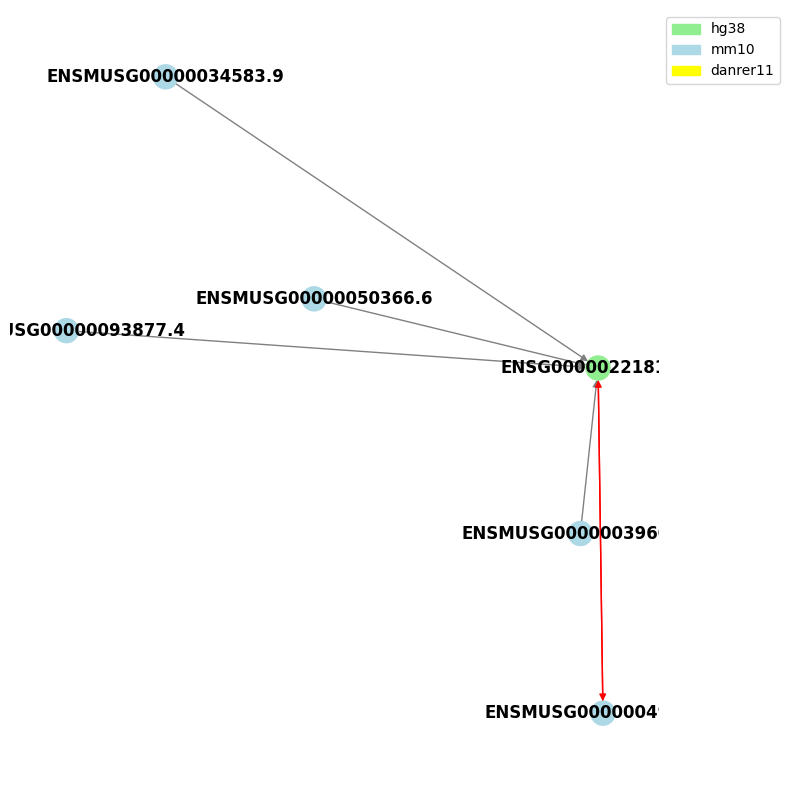

In [21]:
## Only for jupyter
## Plotting components in jupyter
component_number = 506

Ge = G_exon.subgraph(components_exon[component_number])
plot_component(Ge)

#Gg = G_gene.subgraph(components_exon[component_number])
#plot_component(Gg)